In this notebook, we will:
1. Import necessary libraries and custom models.
2. Preprocessing
3. Train and evaluate multiple models.
4. Generate evaluation metrics and visualizations.
5. Prepare a submission file.

In [1]:
## Import Libraries and Custom Models
import pandas as pd
from sklearn.metrics import *
from matplotlib import pyplot as plt

In [2]:
# Import train and accuracy functions from Model classes
from Models.logistic_regression import LogisticRegressionModel
from Models.decision_tree import DecisionTreeModel 
from Models.random_forest import RandomForestModel
from Models.svm import SVCModel
from Models.gradient_boosting import GradientBoostingClassifierModel
from Models.knn import KNeighborsClassifierModel
from Models.naive_bayes import NaiveBayesModel
from Models.ensemble import EnsembleModel

First 5 rows:
    PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  HasCabin  
0      0         A/5 21171   7.2500   NaN        S     False  
1      0          PC 17599  71.2833   C85        C      True  
2      0  STON/O2. 3101282   7.9250   NaN        S     False  
3      0            113803  53.1000  C123        S   

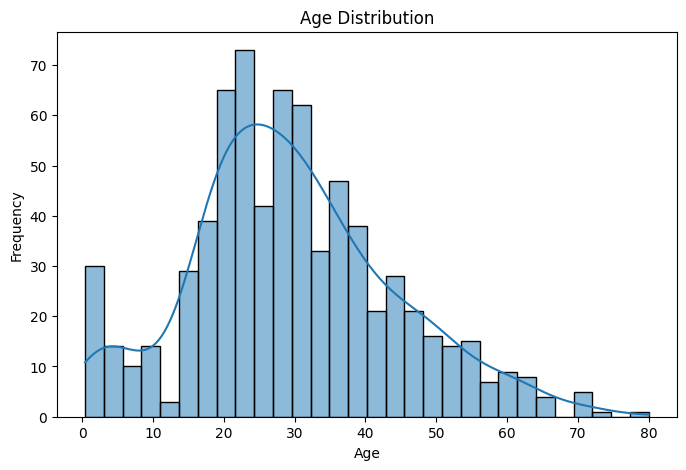

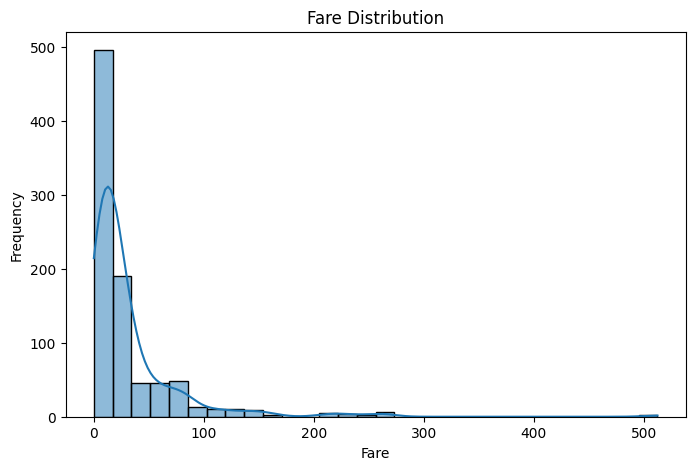

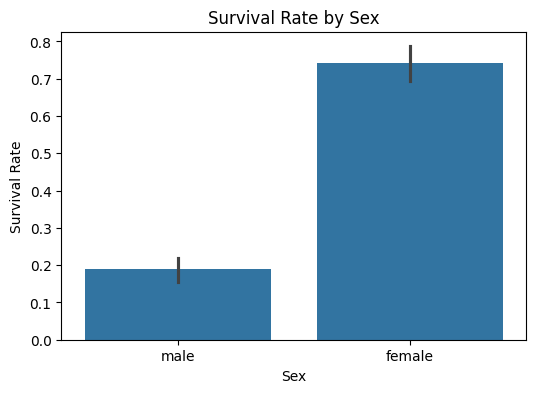

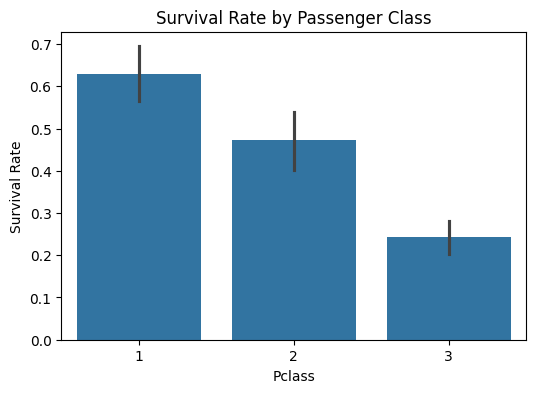

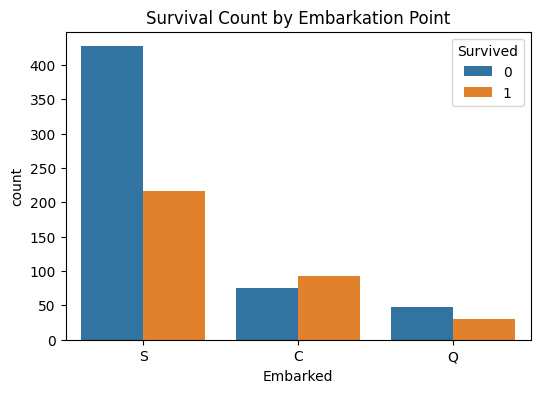

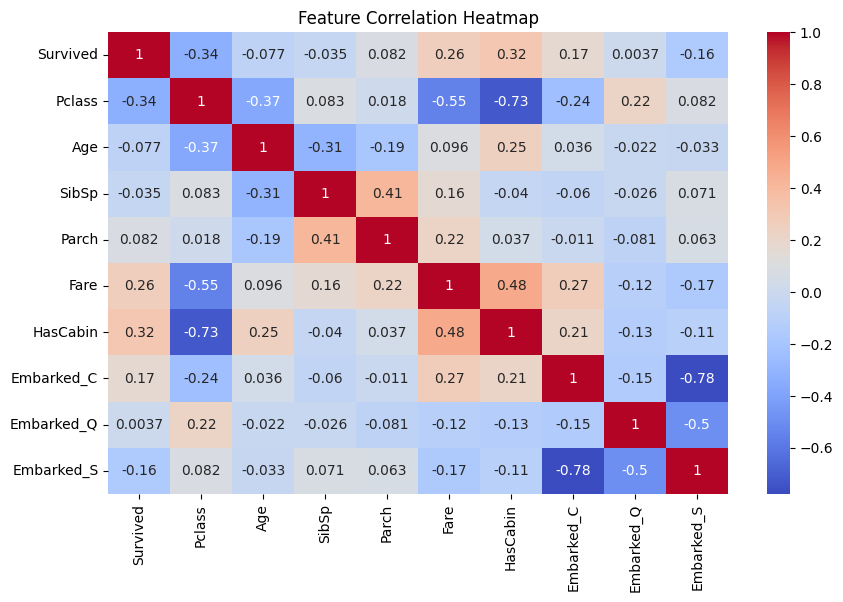

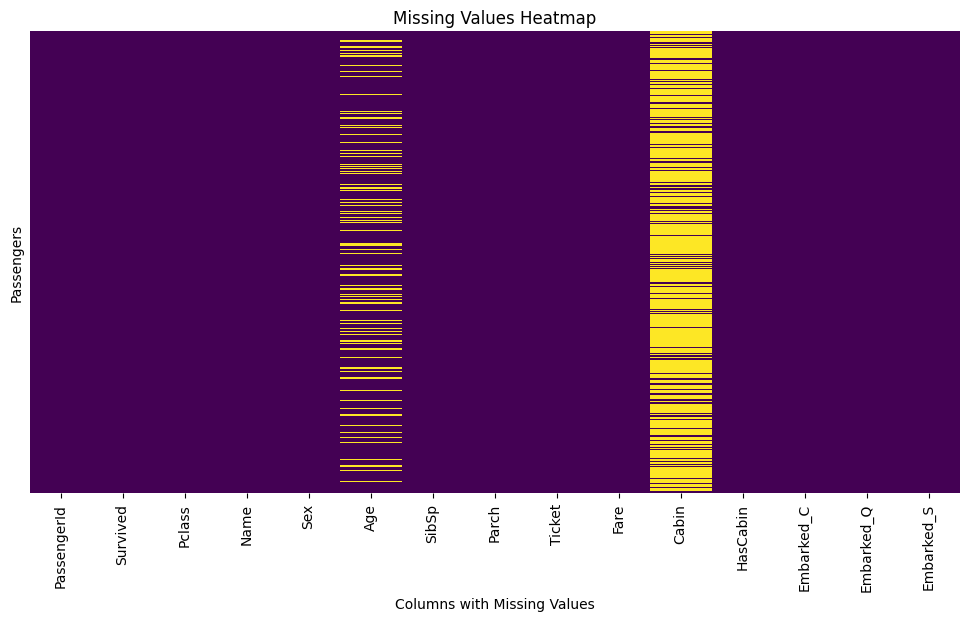

In [3]:
# Run data exploration
%run data_exploration.py

In [4]:
# run preprocessing
%run preprocessing.py

In [5]:
# Load preprocessed data once
X_train = pd.read_csv("Preprocessed_data/X_train_preprocessed.csv")
y_train = pd.read_csv("Preprocessed_data/y_train.csv").squeeze()
X_val   = pd.read_csv("Preprocessed_data/X_val_preprocessed.csv")
y_val   = pd.read_csv("Preprocessed_data/y_val.csv").squeeze()

In [6]:
# Load models we want to train
models = [
    #("Logistic Regression", LogisticRegressionModel()),
    #("Naive Bayes", NaiveBayesModel()),
    #("Decision Tree",        DecisionTreeModel()),
    ("Random Forest",        RandomForestModel()),
    #("SVM",                  SVCModel()),
    #("Gradient Boosting",    GradientBoostingClassifierModel()),
    #("KNN",                  KNeighborsClassifierModel()),
    #("Ensemble",             EnsembleModel())
]


Training Random Forest...
Random Forest - Train Acc: 0.8764, AUC: 0.9448
Random Forest - Val   Acc: 0.8268, AUC: 0.8999
Random Forest - Basic Metrics:
  accuracy: 0.8268
  precision: 0.8282
  recall: 0.8268
  f1_score: 0.8242
  roc_auc: 0.8999


<Figure size 500x400 with 0 Axes>

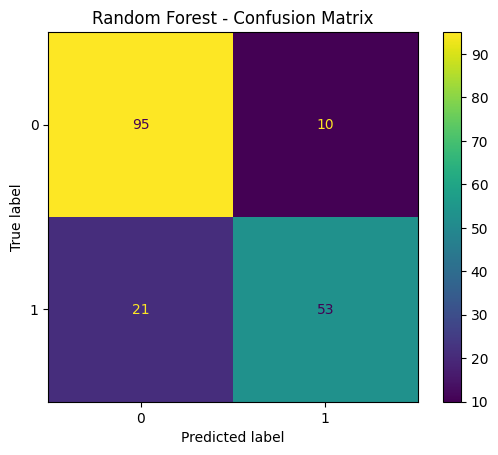

<Figure size 500x400 with 0 Axes>

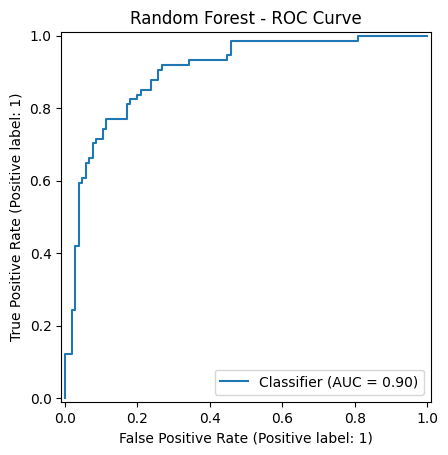


Summary of Model Scores:


,Model,Train Accuracy,Train AUC,Val Accuracy,Val AUC
0,Random Forest,0.876404,0.944828,0.826816,0.899871


In [8]:
results = []

for name, model in models:
    print(f"\nTraining {name}...")
    model.train(X_train, y_train)
    
    # Get and print accuracy and AUC
    train_acc, train_auc = model.get_accuracy(X_train, y_train)
    val_acc,   val_auc   = model.get_accuracy(X_val, y_val)
    print(f"{name} - Train Acc: {train_acc:.4f}, AUC: {train_auc:.4f}")
    print(f"{name} - Val   Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")

    # Collect results for grid
    results.append({
        'Model': name,
        'Train Accuracy': train_acc,
        'Train AUC': train_auc,
        'Val Accuracy': val_acc,
        'Val AUC': val_auc
    })

    # Get predictions and probabilities
    y_pred = model.predict(X_val)
    try:
        y_proba = model.predict_proba(X_val)[:, 1]
    except:
        y_proba = None
        print(f"{name} - predict_proba not supported or failed.")
    
    # Print get_basic_metrics
    basic_metrics = model.get_basic_metrics(X_val, y_val)
    print(f"{name} - Basic Metrics:")
    for metric, value in basic_metrics.items():
        print(f"  {metric}: {value:.4f}" if value is not None else f"  {metric}: None")
    
    # Visualize Confusion Matrix
    plt.figure(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_val, y_pred)
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # Visualize ROC Curve 
    if y_proba is not None:
        plt.figure(figsize=(5,4))
        RocCurveDisplay.from_predictions(y_val, y_proba)
        plt.title(f"{name} - ROC Curve")
        plt.show()

# Display the results grid at the end
results_df = pd.DataFrame(results)
print("\nSummary of Model Scores:")
display(results_df)


In [8]:
%run submission_csv.py

KeyboardInterrupt: 

Training Naive Bayes...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Naive Bayes - Train Acc: 0.7879, AUC: 0.8189
Naive Bayes - Val   Acc: 0.7989, AUC: 0.8403
Naive Bayes - Basic Metrics:
  accuracy: 0.7989
  precision: 0.8044
  recall: 0.7989
  f1_score: 0.8001
  roc_auc: 0.8403

Training Naive Bayes...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Naive Bayes - Train Acc: 0.7879, AUC: 0.8189
Naive Bayes - Val   Acc: 0.7989, AUC: 0.8403
Naive Bayes - Basic Metrics:
  accuracy: 0.7989
  precision: 0.8044
  recall: 0.7989
  f1_score: 0.8001
  roc_auc: 0.8403

Training Random Forest...
Random Forest - Train Acc: 0.8680, AUC: 0.9258
Random Forest - Val   Acc: 0.8045, AUC: 0.8664
Random Forest - Basic Metrics:
  accuracy: 0.8045
  precision: 0.8061
  recall: 0.8045
  f1_score: 0.8008
  roc_auc: 0.8664

Training Random Forest...
Random Forest - Train Acc: 0.8666, AUC: 0.9235
Random Forest - Val   Acc: 0.8101, AUC: 0.8657
Random Forest - Basic Metrics:
  accuracy: 0.8101
  precision: 0.8128
  recall: 0.8101
  f1_score: 0.8061
  roc_auc: 0.8657


Training Logistic Regression...
Logistic Regression - Train Acc: 0.8020, AUC: 0.8517
Logistic Regression - Val   Acc: 0.8212, AUC: 0.8771
Logistic Regression - Basic Metrics:
  accuracy: 0.8212
  precision: 0.8205
  recall: 0.8212
  f1_score: 0.8204
  roc_auc: 0.8771

Training Logistic Regression...
Logistic Regression - Train Acc: 0.8020, AUC: 0.8517
Logistic Regression - Val   Acc: 0.8212, AUC: 0.8771
Logistic Regression - Basic Metrics:
  accuracy: 0.8212
  precision: 0.8205
  recall: 0.8212
  f1_score: 0.8204
  roc_auc: 0.8771

Training Naive Bayes...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Naive Bayes - Train Acc: 0.7879, AUC: 0.8189
Naive Bayes - Val   Acc: 0.7989, AUC: 0.8403
Naive Bayes - Basic Metrics:
  accuracy: 0.7989
  precision: 0.8044
  recall: 0.7989
  f1_score: 0.8001
  roc_auc: 0.8403